# Angular Momentum Alignment Between Stellar Remants and Dark Matter Halos in Galaxy Mergers


In [26]:
# Explain the Goal of My Code
'''
1. Research Topic: Angular Momentum Alignment Between Stellar Remnants and Dark Matter Halos in Galaxy Mergers
2. Specific Question: How does the net angular momentum vector of the merged remnant halo compare to that of the
stellar remnant? Is it aligned? How does it evolve?
3. Goal: Plot the angular momentum alignment angle between the halo and stellar components over time, from pre-merger 
to post-merger.
'''

'\n1. Research Topic: Angular Momentum Alignment Between Stellar Remnants and Dark Matter Halos in Galaxy Mergers\n2. Specific Question: How does the net angular momentum vector of the merged remnant halo compare to that of the\nstellar remnant? Is it aligned? How does it evolve?\n3. Goal: Plot the angular momentum alignment angle between the halo and stellar components over time, from pre-merger \nto post-merger.\n'

In [50]:
# Code Outline
'''
Step 0: Import necessary modules and functions (Read + CenterOfMass)

Step 1: Define functions to calculate angular momentum and separation 

Step 2: Define data file paths and initialize storage arrays

Step 3: Loop through each snapshot from the simulation
    a. Use the Read function to extract time
    b. Use the CenterOfMass class to get COM positions of MW and M31
    c. Calculate the separation between MW and M31

Step 3: Based on separation:
    a. If distance > 30 kpc:
        i. Treat MW and M31 separately
        ii. For each galaxy:
            - Extract halo and disk components
            - Compute net angular momentum vector for each
            - Calculate the angle between L_halo and L_stellar using dot product's property
            - Store time and angle separately for MW and M31
    b. If distance ≤ 30 kpc:
        i. Combine halo and stellar components from MW and M31
        ii. Compute total angular momentum for each component
        iii. Calculate the angle between combined L_halo and L_stellar using dot product's property
        iv. Store time and angle for the merger remnant

Step 4: Plot the angle between halo and stellar angular momentum vectors vs. time
    a. Plot MW and M31 alignment before merger (separately)
    b. Plot the merger remnant alignment after the merging happened (combined MW and M31)
    c. Mark the merger point with a vertical dashed line
'''

"\nStep 0: Import necessary modules and functions (Read + CenterOfMass)\n\nStep 1: Define functions to calculate angular momentum and separation \n\nStep 2: Define data file paths and initialize storage arrays\n\nStep 3: Loop through each snapshot from the simulation\n    a. Use the Read function to extract time\n    b. Use the CenterOfMass class to get COM positions of MW and M31\n    c. Calculate the separation between MW and M31\n\nStep 3: Based on separation:\n    a. If distance > 30 kpc:\n        i. Treat MW and M31 separately\n        ii. For each galaxy:\n            - Extract halo and disk components\n            - Compute net angular momentum vector for each\n            - Calculate the angle between L_halo and L_stellar using dot product's property\n            - Store time and angle separately for MW and M31\n    b. If distance ≤ 30 kpc:\n        i. Combine halo and stellar components from MW and M31\n        ii. Compute total angular momentum for each component\n        iii

In [28]:
# Import modules
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import sys
import os

In [29]:
# Change path to homework3 where the ReadFile.py file is
module_path = r'C:\Users\kietb\OneDrive\Desktop\Suffering\Undergrad\ASTR400B\Homeworks\Homework3'

# Add the directory to sys.path
sys.path.append(module_path)

# Import ReadFile
from ReadFile import Read

In [30]:
# Change path to homework4 where the class CenterOfMass file is
module_path = r'C:\Users\kietb\OneDrive\Desktop\Suffering\Undergrad\ASTR400B\Homeworks\Homework4'

# Add the directory to sys.path
sys.path.append(module_path)

# Import CenterOfMass class
from CenterOfMass import CenterOfMass

In [ ]:
# Function to calculate angular momentum
def angular_momentum(filename, ptype):
    """ Calculate the angle momentum of a specific particle type.
    Parameters
    ----------
    filename : `str`
        Filename of the text file containing the galaxy's particle data.
    ptype : `int`
        type of particle (halo, disk, or bulge) 
        
    Returns
    -------------
     L : `np.array` 
    Angular momentum vector (Lx, Ly, Lz) of the specified particle type relative to the galaxy's COM, computed as:

    L = sum(m_i * (r_i - r_COM) × (v_i - v_COM))

    where:
        - m_i is the mass of particle i
        - (r_i - r_COM) is the particle's position relative to the galaxy's COM
        - (v_i - v_COM) is the particle's velocity relative to the galaxy's COM
        - × is the vector cross product operation
    """

    # Create a COM object for MW galaxy
    COM = CenterOfMass(filename, ptype)
    
    # Get COM position and velocity
    com_pos = COM.COM_P(0.1)
    com_vel = COM.COM_V(com_pos[0], com_pos[1], com_pos[2])

    # Remove units from com_pos and com_vel
    com_pos = com_pos.to(u.kpc).value
    com_vel = com_vel.to(u.km/u.s).value

    # Read particle data
    time, total, data = Read(filename)
    
    # Select particle type
    index = np.where(data['type'] == ptype)
    

    # Positions and velocities relative to COM
    pos_rel = np.array([data['x'][index] - com_pos[0],
                        data['y'][index] - com_pos[1],
                        data['z'][index] - com_pos[2]])
    vel_rel = np.array([data['vx'][index] - com_vel[0],
                        data['vy'][index] - com_vel[1],
                        data['vz'][index] - com_vel[2]])
    
    # Masses
    m = data['m'][index]

    # Calculate angular momentum L = sum(m * (r x v))
    # Initialize angular momentum vector
    L = np.zeros(3)

# Loop through each particle to explicitly calculate angular momentum
    for i in range(len(m)):
        r = pos_rel[:, i]      # Position vector of particle i relative to COM
        v = vel_rel[:, i]      # Velocity vector of particle i relative to COM
        L += m[i] * np.cross(r, v)  # Summation of individual particle's angular momentum

    return L

In [55]:
# Define paths to MW and M31 snapshot data folders
path_MW = r"C:\Users\kietb\OneDrive\Desktop\Suffering\Undergrad\ASTR400B\Research_Assignments\Research_Assignment_3\MW"
path_M31 = r"C:\Users\kietb\OneDrive\Desktop\Suffering\Undergrad\ASTR400B\Research_Assignments\Research_Assignment_3\M31"

In [ ]:
# Function to measure distance between MW and M31 centers
def separation_distance(snap):
    """Calculate the  separation between the MW and M31 galaxies using the positions of their disk 
    particles at a given snapshot.

    Parameters
    ----------
    snap : `int`
        Snapshot number (e.g., 000, 050, 100...)

    Returns
    -------
    dist : `float`
        The distance between MW and M31 (kpc).
    """

    # Extract snapshot
    fname_MW = f"{path_MW}\\MW_{snap:03}.txt"
    fname_M31 = f"{path_M31}\\M31_{snap:03}.txt"

    # Calculate the COM for each snapshot using the disk particles (type 2)
    COM_MW = CenterOfMass(fname_MW, 2)  
    COM_M31 = CenterOfMass(fname_M31, 2)

    # Get COM position for each snapshot
    r_MW = COM_MW.COM_P(0.1).value
    r_M31 = COM_M31.COM_P(0.1).value
    
    # Calculate the separation 
    dist = np.linalg.norm(r_MW - r_M31) 
    return dist

In [ ]:
# Empty arrays to store MW data
mw_times = []
mw_angles = []

# Empry arrays to store M31 data
m31_times = []
m31_angles = []

# Empty arrays to store merger data
merger_times = []
merger_angles = []

In [ ]:
# Loop through snapshots
for snap in np.arange(0, 801, 50):
    # Extract snapshots from data files
    fname_MW = f"{path_MW}\\MW_{snap:03}.txt"
    fname_M31 = f"{path_M31}\\M31_{snap:03}.txt"

    # Read time
    time, _, _ = Read(fname_MW)
    t_gyr = time.to(u.Gyr).value # convert time to Gyr

    # Measure distance to determine if merger occured
    dist = separation_distance(snap)

    # Case 1: Before merger (assume distance > 30 kpc) — treat MW and M31 separately
    if dist > 30: 
        # MW angular momentum
        L_halo_MW = angular_momentum(fname_MW, 1)
        L_star_MW = angular_momentum(fname_MW, 2)

        # cos theta = dot product / product of magnitude
        dot_mw = np.dot(L_halo_MW, L_star_MW)  # dot product
        mag_mw = np.linalg.norm(L_halo_MW) * np.linalg.norm(L_star_MW)  # product of magnitudes
        cos_theta_mw = dot_mw / mag_mw  # cosine of the angle

        # theta = arccos(cos(theta))
        # np.clip to prevent rounding errors (-1 <= cos(theta) <= 1)
        angle_mw = np.degrees(np.arccos(np.clip(cos_theta_mw, -1 , 1)))

        # Save MW times and alignment
        mw_times.append(t_gyr)
        mw_angles.append(angle_mw)

        # M31 angular momentum
        L_halo_M31 = angular_momentum(fname_M31, 1)
        L_star_M31 = angular_momentum(fname_M31, 2)

        # cos theta = dot product / magnitude
        dot_m31 = np.dot(L_halo_M31, L_star_M31)  # dot product
        mag_m31 = np.linalg.norm(L_halo_M31) * np.linalg.norm(L_star_M31)  # product of magnitudes
        cos_theta_m31 = dot_m31 / mag_m31  # cosine of the angle

        # theta = arccos(cos(theta))
        # np.clip to prevent round errors (-1 <= cos(theta) <= 1)
        angle_m31 = np.degrees(np.arccos(np.clip(cos_theta_m31, -1 , 1)))

        # Save M31 times and alignment
        m31_times.append(t_gyr)
        m31_angles.append(angle_m31)

    # Case 2: After merger (assume distance <= 30 kpc) — combine MW + M31 components
    else:
        # Merger angular momentum
        L_halo_merger = angular_momentum(fname_MW, 1) + angular_momentum(fname_M31, 1)
        L_star_merger = angular_momentum(fname_MW, 2) + angular_momentum(fname_M31, 2)

        # cos theta = dot product / product of magnitude
        dot_merger = np.dot(L_halo_merger, L_star_merger) # dot product
        mag_merger = np.linalg.norm(L_halo_merger) * np.linalg.norm(L_star_merger) # product of magnitudes
        cos_theta_merger = dot_merger / mag_merger # cosine of the angle

        # theta = arccos(cos(theta))
        # np.clip to prevent rounding errors (-1 <= cos(theta) <= 1)
        angle_merger = np.degrees(np.arccos(np.clip(cos_theta_merger, -1 , 1))) 

        # Save merger times and alignment
        merger_times.append(t_gyr)
        merger_angles.append(angle_merger)

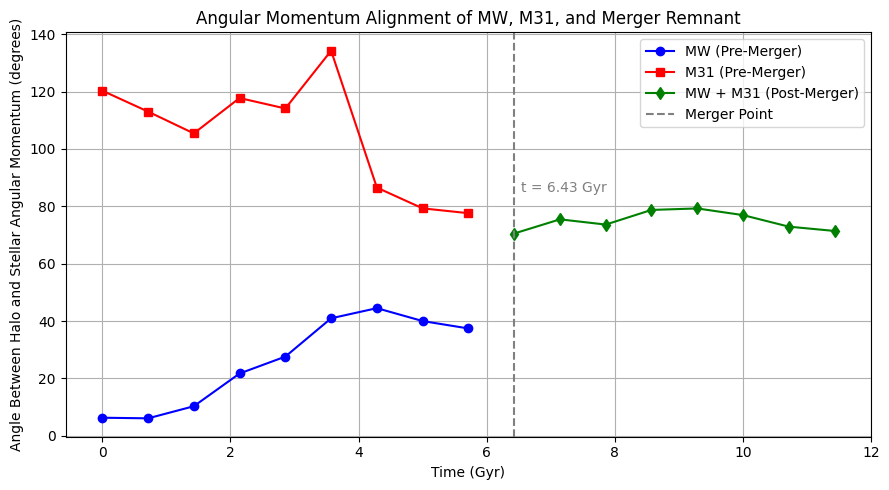

In [ ]:
# Plot
plt.figure(figsize=(9, 5))

# Plot MW before merger
plt.plot(mw_times, mw_angles, marker ='o', color='blue', label='MW (Pre-Merger)')

# Plot M31 before merger
plt.plot(m31_times, m31_angles, marker ='s', color='red', label='M31 (Pre-Merger)')

# Plot merger
plt.plot(merger_times, merger_angles, marker ='d', color='green', label='MW + M31 (Post-Merger)')

# Mark the time merger occurs
if merger_times:
    merger_time = merger_times[0]
    plt.axvline(x=merger_time, color='gray', linestyle='--', label='Merger Point')

    # Label merger time above the vertical line
    plt.text(merger_time + 0.1, 85, f't = {merger_time:.2f} Gyr', color='gray')


# Labels and layout
plt.xlabel('Time (Gyr)')
plt.ylabel('Angle Between Halo and Stellar Angular Momentum (degrees)')
plt.title('Angular Momentum Alignment of MW, M31, and Merger Remnant')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("Angular_Momentum_MW_M31_Merger.png")
plt.show()